# Hi

In [55]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from pandas import date_range
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('train.csv')  
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [7]:
df['store_nbr'].value_counts()

store_nbr
1     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
9     55572
Name: count, dtype: int64

In [8]:
df['family'].value_counts()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

* I realized some unnecessary rows in the data while I was looking at the time serie of the stores one by one. If you select the stores from above, some of them have no sales at the beginning of 2013. You can see them, if you look at the those stores 20, 21, 22, 29, 36, 42, 52 and 53. I decided to remove those rows before the stores opened. In the following codes, we will get rid of them.

* from: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

In [9]:
print(df.shape)
df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]
df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]
df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]
df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]
df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]
df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]
df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]
df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]
df.shape

(3000888, 6)


(2780316, 6)

In [10]:
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc['2017',['sales', 'onpromotion']]
)

df.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0
                     2013-01-03  3564    3.0            0
                     2013-01-04  5346    3.0            0
                     2013-01-05  7128    5.0            0

In [11]:
family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['sales', 'onpromotion']]
)

In [12]:
auto_sales = family_sales.loc(axis=1)[:, 'AUTOMOTIVE']
auto_sales.head()

,sales,onpromotion
family,AUTOMOTIVE,AUTOMOTIVE
date,,
2013-01-01,0.000000,0.0
2013-01-02,5.543478,0.0
2013-01-03,3.500000,0.0
2013-01-04,3.673913,0.0
2013-01-05,7.434783,0.0


C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\675341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')


<Axes: xlabel='sales', ylabel='family'>

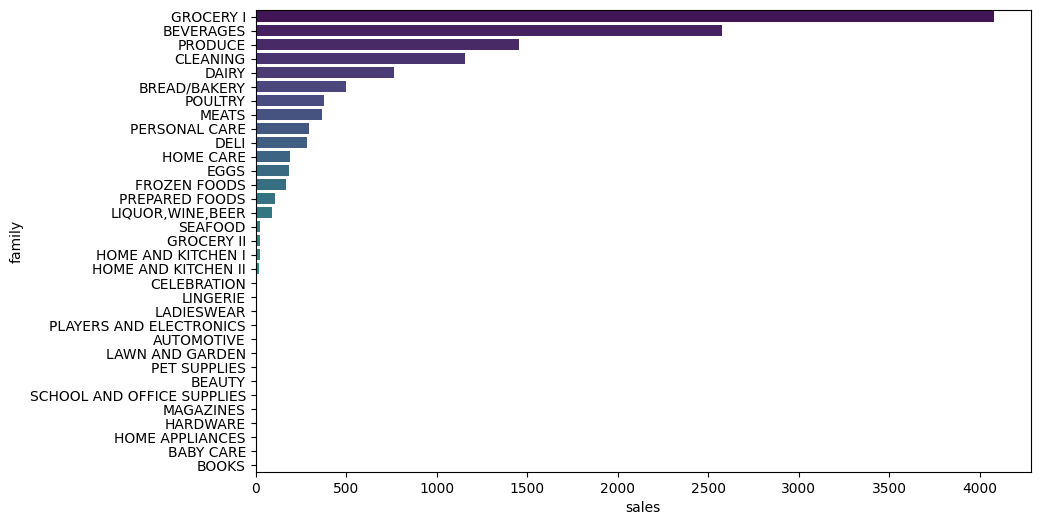

In [13]:
a = df.groupby('family').sales.mean().sort_values(ascending = False).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')

* The "GROCERY I" category likely includes essential, frequently purchased food items and household staples such as:

* Packaged foods (e.g., rice, pasta, canned goods)

* Non-perishable snacks

* Beverages (like juices and soft drinks)

* Baking supplies (e.g., flour, sugar)

* Pantry essentials (e.g., sauces, spices)

* Breakfast items (e.g., cereals, oats)

* In retail data, categories like "GROCERY I" and "GROCERY II" are often separated to distinguish between high-frequency essential products (GROCERY I) and less frequent purchases (GROCERY II). The exact contents can vary depending on the dataset's classification scheme.* 

# Analysis of Top Categories

## Beverages

In [14]:
beverages_sales = family_sales.loc(axis=1)[:, 'BEVERAGES']
beverages_sales.head()

,sales,onpromotion
family,BEVERAGES,BEVERAGES
date,,
2013-01-01,17.608696,0.0
2013-01-02,1567.217391,0.0
2013-01-03,1132.717391,0.0
2013-01-04,1177.543478,0.0
2013-01-05,1691.695652,0.0


<Figure size 2000x400 with 0 Axes>

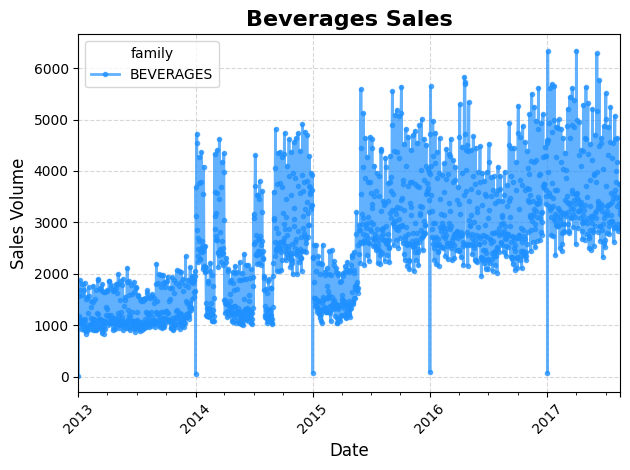

In [15]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
beverages_sales['sales'].plot(
    title='Beverages Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Beverages Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

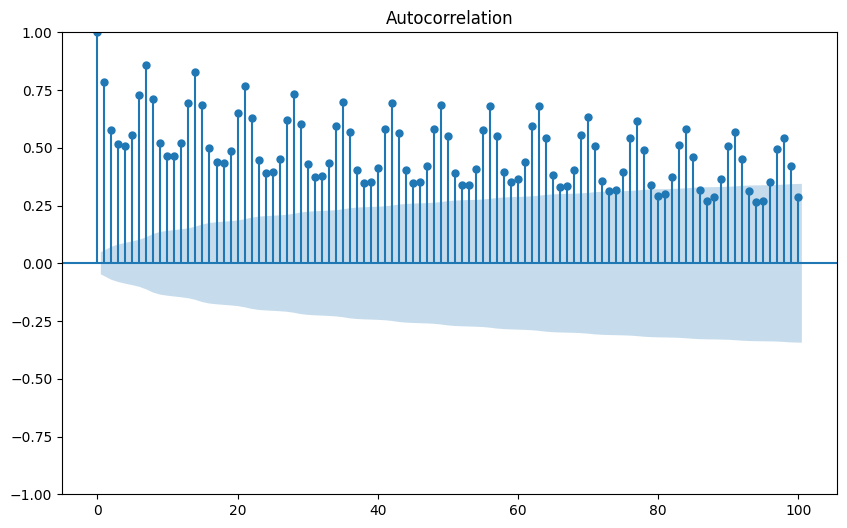

In [16]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


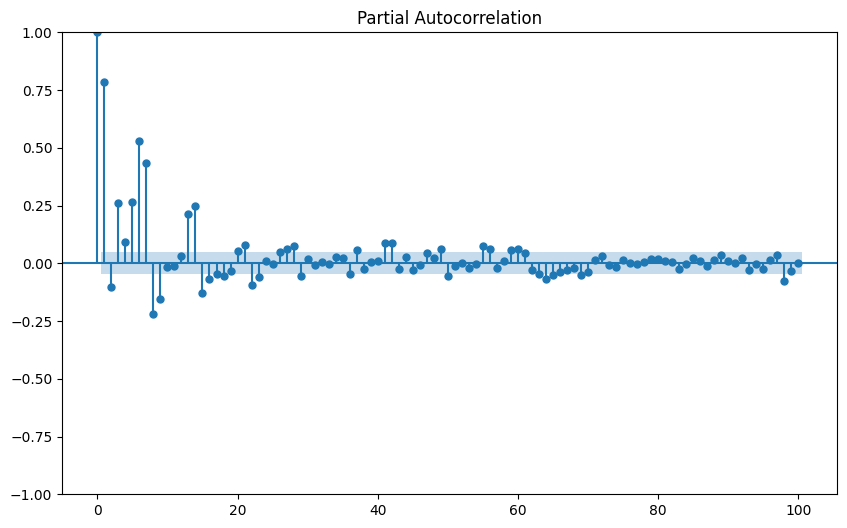

In [17]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


In [18]:
print(beverages_sales.columns)


MultiIndex([(      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


In [19]:
print(beverages_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [20]:
print(beverages_sales.reset_index().columns)

MultiIndex([(       'date',          ''),
            (      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


### Moving Average('Trend')

<Axes: title={'center': 'Beverages Sales Trend'}, xlabel='date'>

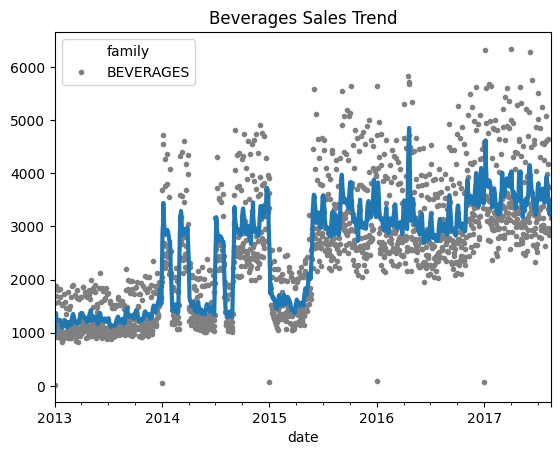

In [21]:
trend = beverages_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = beverages_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Beverages Sales Trend', legend=False) # plot the trend

### Forecast trend

In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = beverages_sales[('sales', 'BEVERAGES')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 3, # the time dummy (trend)
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [23]:
X

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.000000e+00
2013-01-02,2.0,4.0,8.000000e+00
2013-01-03,3.0,9.0,2.700000e+01
2013-01-04,4.0,16.0,6.400000e+01
2013-01-05,5.0,25.0,1.250000e+02
...,...,...,...
2017-08-11,1680.0,2822400.0,4.741632e+09
2017-08-12,1681.0,2825761.0,4.750104e+09
2017-08-13,1682.0,2829124.0,4.758587e+09


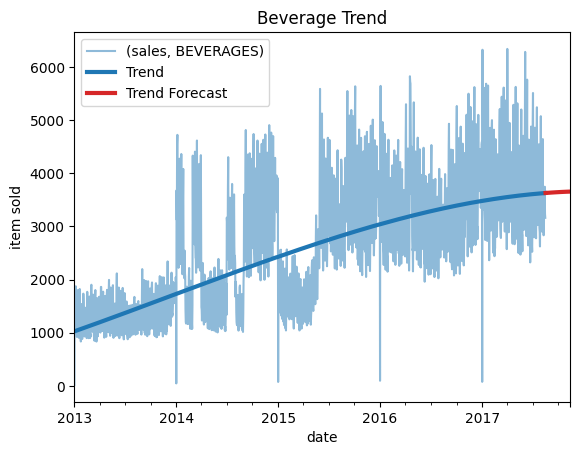

In [24]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Beverage Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\412866805.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')


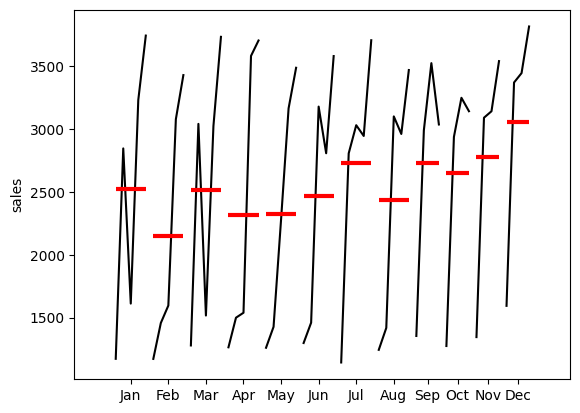

In [25]:
# Plot the monthly seasonality

month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\3019437212.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')


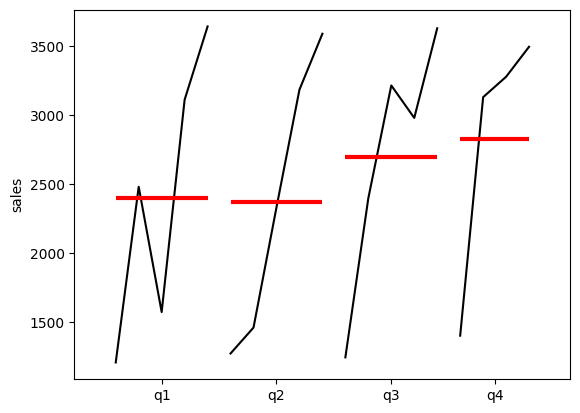

In [26]:
quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\512417244.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = beverages_sales['sales'].resample('W').mean()


<Figure size 1200x600 with 0 Axes>

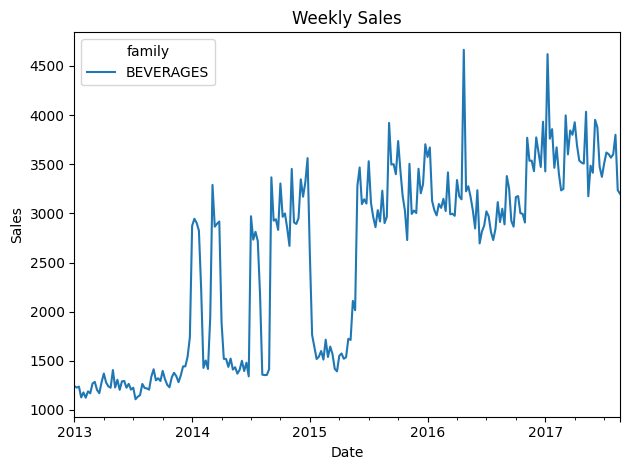

In [27]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = beverages_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,6))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

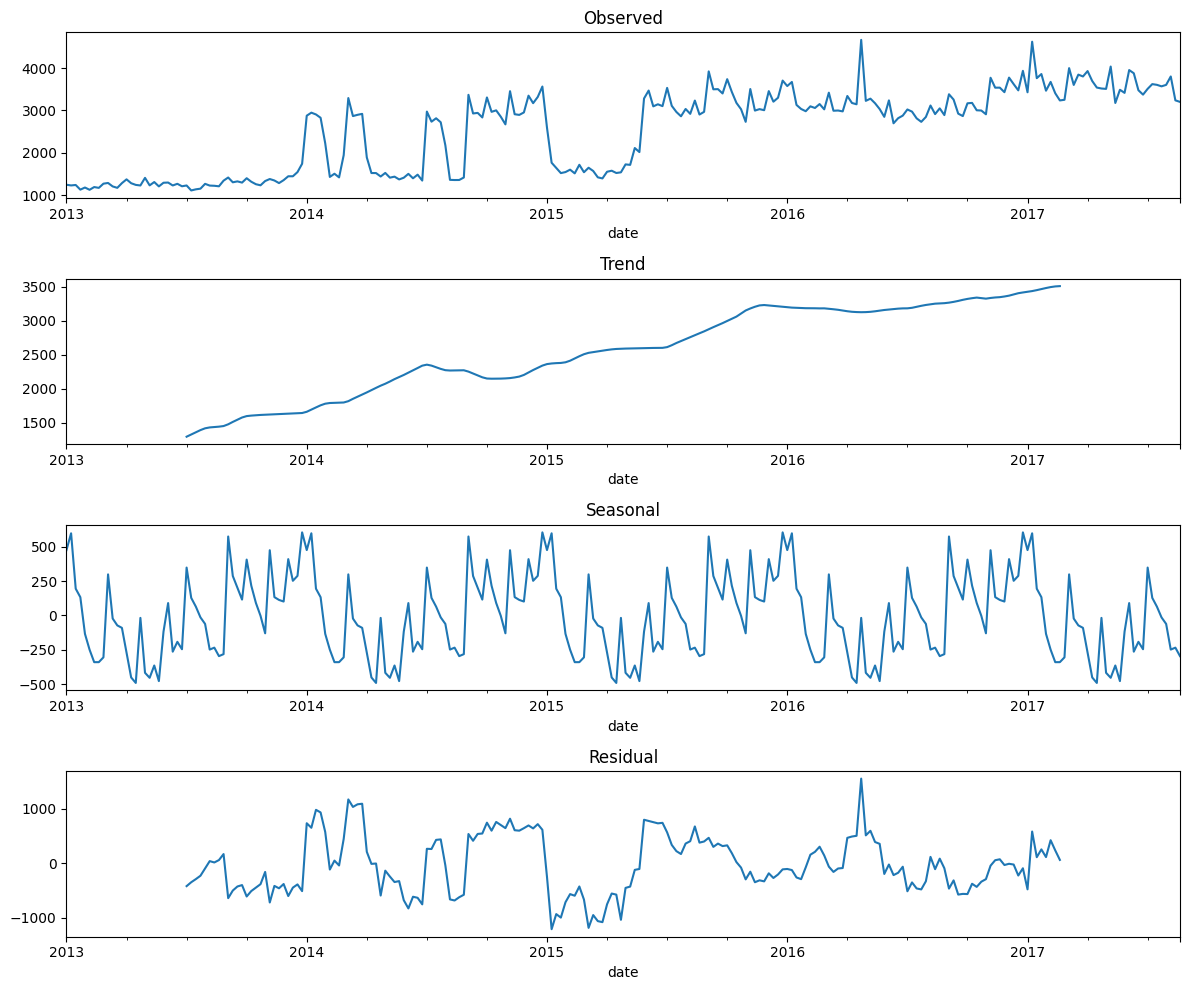

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)  # 52 weeks in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

## Produce


In [29]:
produce_sales = family_sales.loc(axis=1)[:, 'PRODUCE']
produce_sales.head()

,sales,onpromotion
family,PRODUCE,PRODUCE
date,,
2013-01-01,0.0,0.0
2013-01-02,0.0,0.0
2013-01-03,0.0,0.0
2013-01-04,0.0,0.0
2013-01-05,0.0,0.0


<Figure size 2000x400 with 0 Axes>

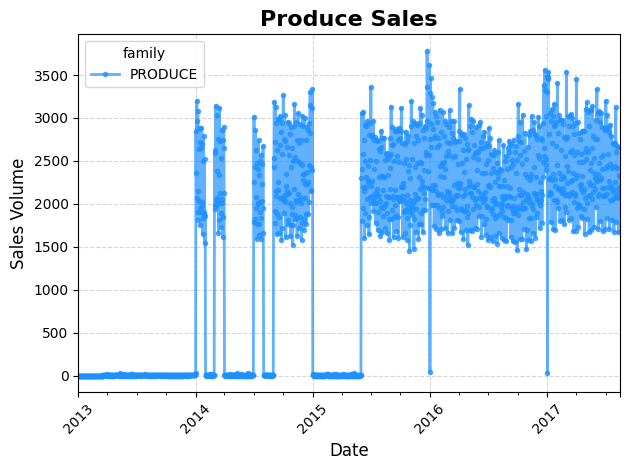

In [30]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
produce_sales['sales'].plot(
    title='Produce Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Produce Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

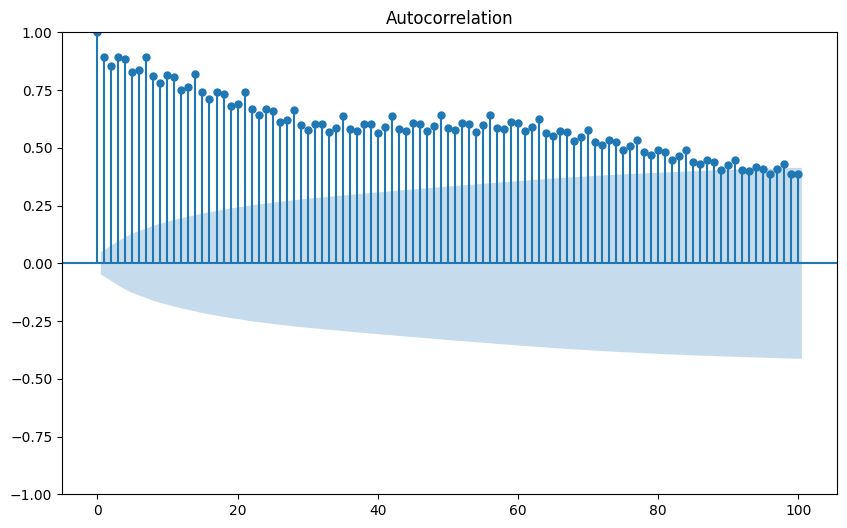

In [31]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


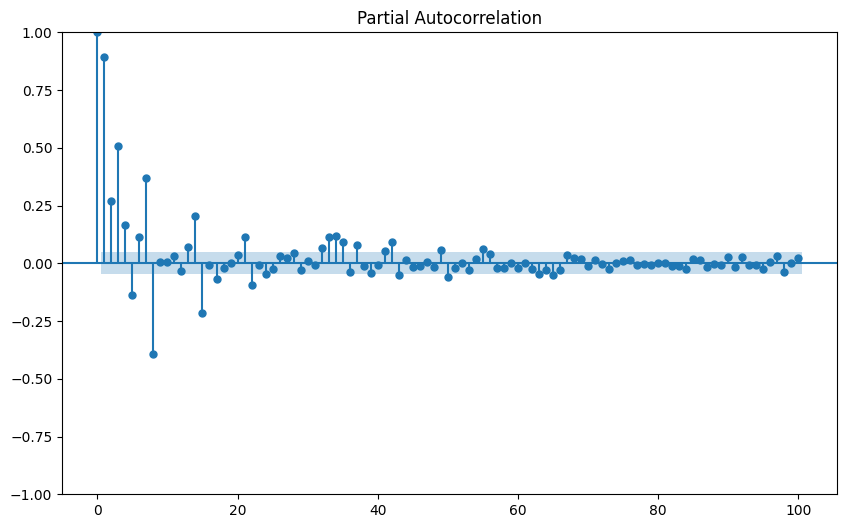

In [32]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


In [33]:
print(produce_sales.columns)


MultiIndex([(      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


In [34]:
print(produce_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [35]:
print(produce_sales.reset_index().columns)

MultiIndex([(       'date',        ''),
            (      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


### Trend


<Axes: title={'center': 'Produce Sales Trend'}, xlabel='date'>

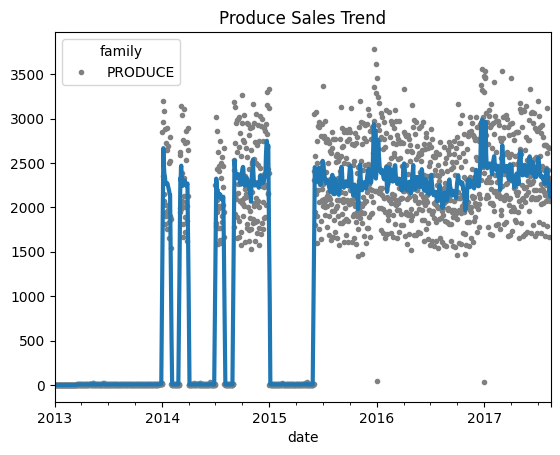

In [36]:
trend = produce_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = produce_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Produce Sales Trend', legend=False) # plot the trend

In [37]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = produce_sales[('sales', 'PRODUCE')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 2, # the time dummy (trend) # if u make the order too high the trend will fall
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [38]:
X

,trend,trend_squared
date,,
2013-01-01,1.0,1.0
2013-01-02,2.0,4.0
2013-01-03,3.0,9.0
2013-01-04,4.0,16.0
2013-01-05,5.0,25.0
...,...,...
2017-08-11,1680.0,2822400.0
2017-08-12,1681.0,2825761.0
2017-08-13,1682.0,2829124.0


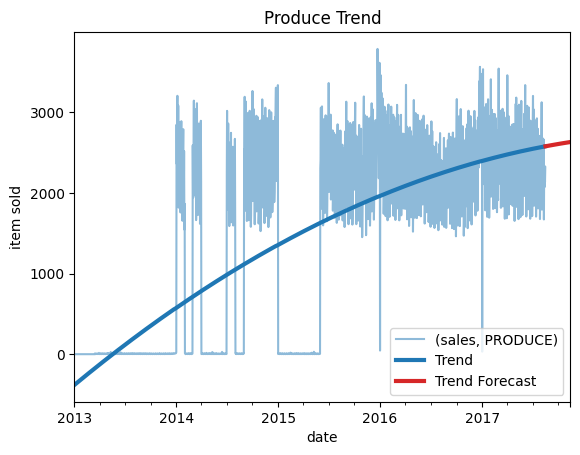

In [39]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Produce Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\1107100198.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')


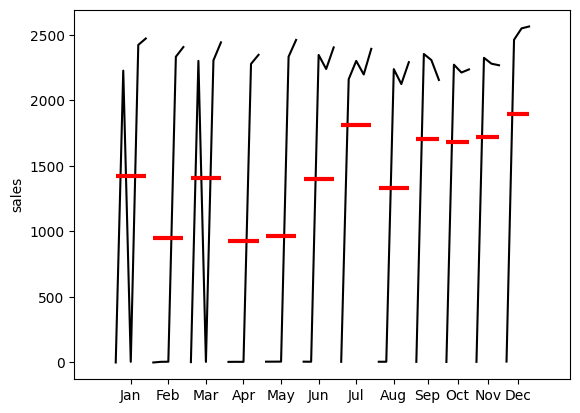

In [40]:
# Plot the monthly seasonality

month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\3570960343.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')


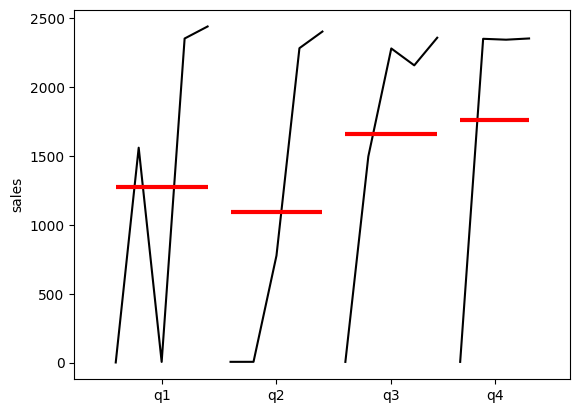

In [41]:
quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\1159680694.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = produce_sales['sales'].resample('W').mean()


<Figure size 1200x400 with 0 Axes>

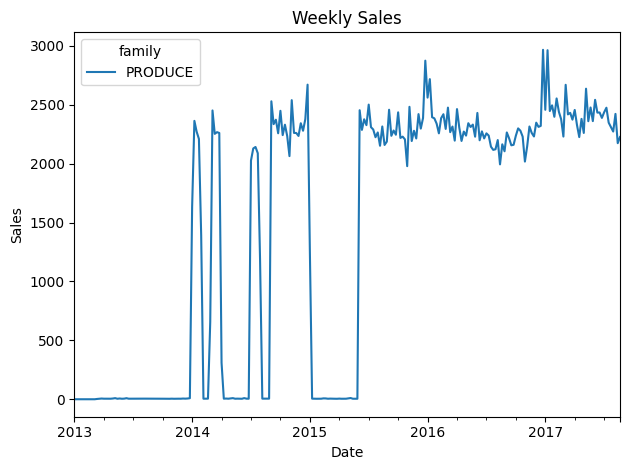

In [42]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = produce_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,4))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

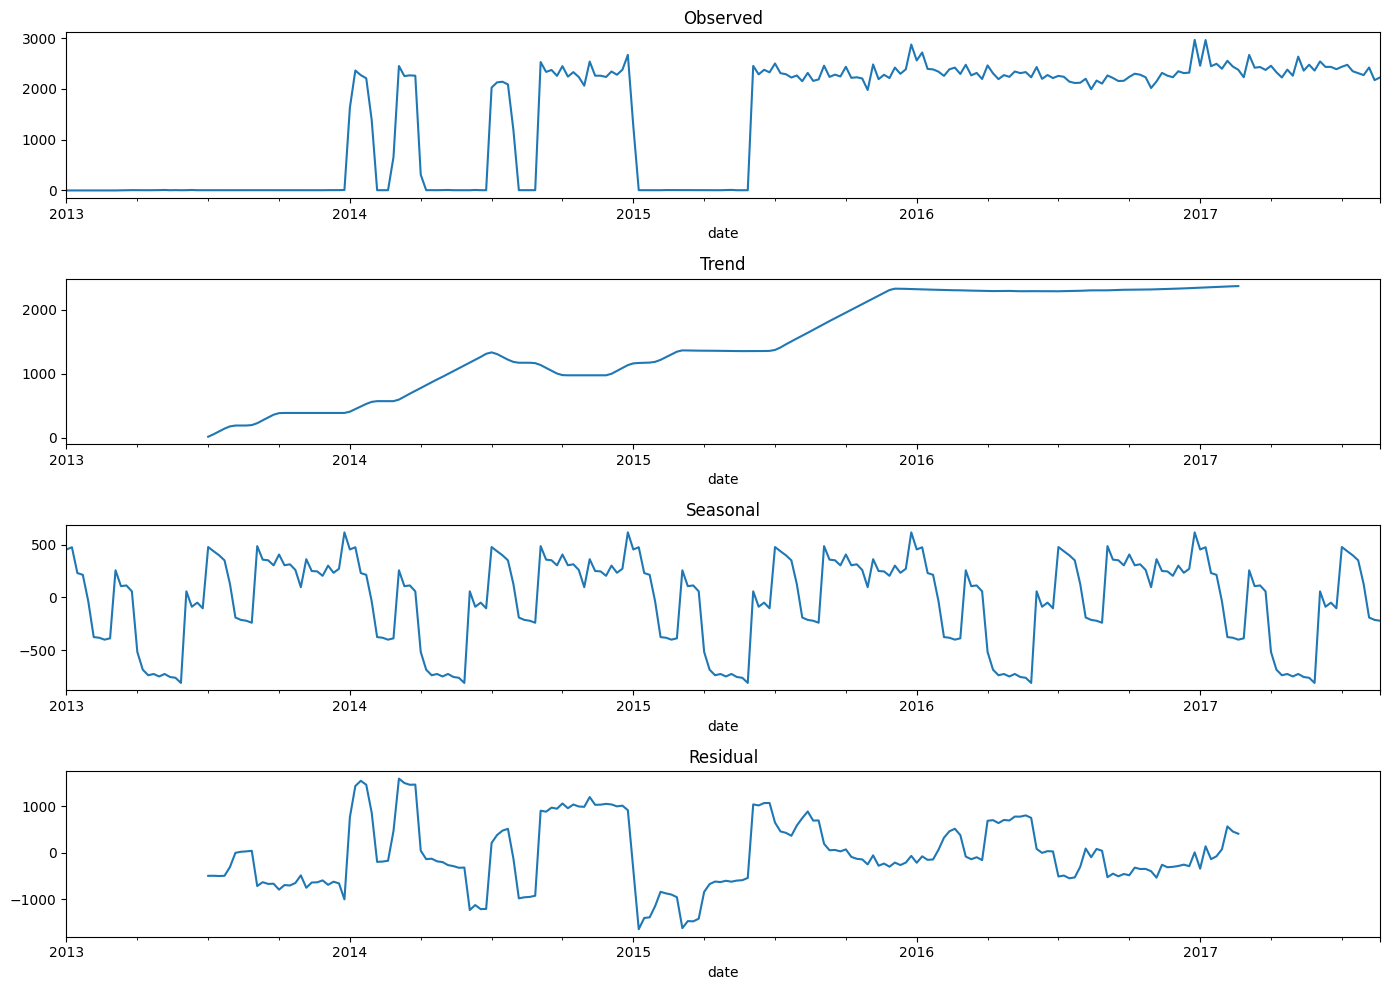

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure proper timestamp index
sales = produce_sales['sales'].copy()
# sales.index = pd.to_datetime(sales.index)
sales = sales.to_timestamp()
# Resample to weekly mean
weekly_sales = sales.resample('W').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)

# Plot full decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# Modeling

In [44]:
# You'll add fit and predict methods to this minimal class

class boostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [46]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    # make predictions with self.model_1
    y_fit = pd.Dataframe(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns
    )
    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    #  fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns

    self.y_fit = y_fit
    self.y_resid = y_resid

# Add method to class
boostedHybrid.fit = fit

In [49]:
def predict(X_1, X_2):
    y_pred = pd.DataFrame(
        model_1.predict(X1), 
        index = X_1.index, columns=y_columns
    )

    y_pred = ypred.stack.squeeze() # wide too long

    y_pred += self.model_2.predict(X_2) # add self.model_2 predictions to y_pred

    return y_pred.unstack() # long to wide

boostedHybrid.predict = predict



In [53]:
y = family_sales.loc[:, 'sales']

dp = DeterministicProcess(index=y.index, order=1) # trend (order 1 means linear)
X_1 = dp.in_sample()

# X_2 are xgboost features

X_2 = family_sales.drop('sales', axis=1).stack() # onpromotion

# Label encoding for column 'family' 
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

X_2['day'] = X_2.index.day

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\3876049266.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = family_sales.drop('sales', axis=1).stack() # onpromotion


Create the hybrid model by initializing a BoostedHybrid class with LinearRegression() and XGBRegressor() instances.

In [57]:
model = boostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor()
)